In [1]:
import pandas as pd
import numpy as np

# Import Geocoder to get each area's coordinates
#!conda install -c conda-forge geocoder             #Uncomment this if geocoder is not installed on your system
import geocoder # import geocoder

# Import k-means for clustering stage
from sklearn.cluster import KMeans
# MinMaxScaler for normalization : to find the best K for K-Means
from sklearn.preprocessing import MinMaxScaler

# Import Folium to draw maps
#!conda install -c conda-forge folium                #Uncomment this if folium is not installed on your system
import folium

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Import Requests for querying FoursquareAPI
import requests

In [2]:

CONST_demographicDataLink = "https://www.toronto.ca/ext/open_data/catalog/data_set_files/2016_neighbourhood_profiles.csv"

In [3]:
CLIENT_ID = 'HKQ14COL3QJT3YG01WRQ5XUYKQVJ2EXFNWXUFTAXSSOWK35V' # your Foursquare ID
CLIENT_SECRET = 'JXTFP1CN4LMMRRU1F52APNGI5CDECBVAEZAGNLGVKEBJAPIT' # your Foursquare Secret

VERSION = '20180605' # Foursquare API version

# Size of the radius to retrieve venues from FoursquareAPI, and limit of venues per neighbourhood
CONST_venuesRadiusScan = 1000
CONST_venuesLimit = 1000

In [4]:
df_raw = pd.read_csv(CONST_demographicDataLink, encoding = "cp1252", thousands=',')

In [5]:
# Get only data about areas information : filter on Characteristic
df_cityAreas = df_raw[df_raw.Characteristic == "Neighbourhood Number"]

# Drop the useless columns, only keep CDN x City_Area
df_cityAreas = df_cityAreas.drop(df_cityAreas.columns[[0,1,2,3,4]], axis=1)

# Format the dataframe
df_cityAreas = df_cityAreas.transpose()
df_cityAreas = df_cityAreas.reset_index()
df_cityAreas = df_cityAreas.iloc[:, ::-1]
df_cityAreas.columns = ['CDN', 'City_Area']
df_cityAreas.head()

,CDN,City_Area
0,129,Agincourt North
1,128,Agincourt South-Malvern West
2,20,Alderwood
3,95,Annex
4,42,Banbury-Don Mills


In [6]:
def countLeadingSpaces(str):
    return len(str) - len(str.lstrip())

In [7]:
df_demographic = df_raw.apply(lambda x: x.str.replace(',',''))

# Filter on Topic = 'Ethnic origin population' to retrieve data about ethnic origins only
df_demographic = df_demographic[df_demographic.Topic == 'Ethnic origin population']

# Calculate the depth of Ethnic origin
df_demographic['Depth'] = df_demographic['Characteristic']

for index, row in df_demographic.iterrows():
    # The depth of Ethnic origin is calculated using the leading spaces in the data
    row['Depth'] = countLeadingSpaces(row['Depth'])

# Find each depth level of Ethnic origin, so we will be able to only keep the deepest levels
df_demographic['newLevel'] = np.where((df_demographic['Depth'].shift(+1) > df_demographic['Depth']),"new","")
    
# Reverse the dataframe
df_demographic = df_demographic.iloc[::-1]

In [8]:

# Keep value will tell us if we need to keep the row (deepest level) or if we need to drop it
df_demographic['Keep'] = 0
tmpDepth = ""

# Loop through each row
for index, row in df_demographic.iterrows():
    # We keep the first element, because the dataframe has been reversed so the first row is a deepest level
    if tmpDepth == "":
        df_demographic.loc[index, 'Keep'] = 1
        
        # We keep the current level of depth in a temp variable, so we will be able to compare it in the next row iterration
        tmpDepth = row['Depth']
    
    else:
        # If the depth level of the previous row equals the depth level of the current row : same depth, so we keep the row
        if tmpDepth == row['Depth']:
            df_demographic.loc[index, 'Keep'] = 1
        
        # New level : we reset the temp variable
        elif row['newLevel'] == "new":
            # Reset tmpDepth
            tmpDepth = ""
            
# Reverse the dataframe
df_demographic = df_demographic.iloc[::-1]

# Keep only the necessary rows
df_demographic = df_demographic[df_demographic.Keep == 1]

# Drop the useless columns
df_demographic = df_demographic.drop(['Depth', 'newLevel', 'Keep'], 1)
df_demographic.head()

,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
1348,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,First Nations (North American Indian),27610,25,90,200,345,175,...,60,110,470,355,235,275,90,130,200,85
1349,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Inuit,515,0,0,15,20,10,...,0,0,25,0,0,10,0,0,0,0
1350,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Métis,8465,10,25,100,115,60,...,40,35,110,80,60,80,45,75,40,10
1352,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,Acadian,2315,20,0,10,60,0,...,0,0,10,45,20,30,10,0,10,0
1353,Ethnic origin,Ethnic origin population,Census Profile 98-316-X2016001,American,27470,40,70,100,705,325,...,155,145,140,275,95,275,320,280,175,100


In [9]:

df_demographic.drop(df_demographic.columns[[0, 1, 2, 4]], axis=1, inplace=True)
df_demographic.rename(columns={'Characteristic':''}, inplace=True)

# Put the city areas names as the dataframe columns
df_demographic = df_demographic.transpose()
df_demographic.columns = df_demographic.iloc[0]
df_demographic = df_demographic.iloc[1:]

# Drop the Total column as we won't use it
df_demographic.drop(df_demographic.columns[[0]], axis=1, inplace=True)

# Format the dataframe
df_demographic = df_demographic.reset_index()
df_demographic.rename(columns={'index':'City_Area'}, inplace=True)
df_demographic.head()

,City_Area,Inuit,Métis,Acadian,American,Canadian,New Brunswicker,Newfoundlander,Nova Scotian,Ontarian,...,Tibetan,Vietnamese,East and Southeast Asian origins; n.i.e.,Other Asian origins; n.i.e.,Fijian,Hawaiian,Maori,Polynesian; n.o.s.,Samoan,Pacific Islands origins; n.i.e.
0,Agincourt North,0,10,20,40,1295,0,10,0,0,...,0,320,20,135,0,0,0,0,0,0
1,Agincourt South-Malvern West,0,25,0,70,1125,0,0,0,0,...,0,180,10,55,0,0,0,0,0,0
2,Alderwood,15,100,10,100,2245,0,15,0,0,...,110,45,0,0,0,0,0,0,0,0
3,Annex,20,115,60,705,4655,0,10,10,0,...,0,145,15,25,0,0,10,0,0,10
4,Banbury-Don Mills,10,60,0,325,3035,0,0,10,0,...,0,115,0,45,0,0,10,0,0,0


In [10]:
# This function returns the latitude and longitude of the given postal code, in Toronto
def getCoordsByCityArea(area):
    # initialize to None : this variable will allow us to loop until geocoder responds with the coordinates
    lat_lng_coords = None

    # loop until we get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(area))
        lat_lng_coords = g.latlng

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    
    return latitude, longitude

In [11]:
areasWithCoordsList = []

# Loop through each postal code from our dataframe
for area in df_cityAreas['City_Area']:
    # Fill the temp list with the coordinates from geocoder
    latitude, longitude = getCoordsByCityArea(area)
    areasWithCoordsList.append([area, latitude, longitude])
    
# Transform the temp list into a dataframe
df_coords = pd.DataFrame(areasWithCoordsList)
df_coords.columns = ['City_Area', 'Latitude', 'Longitude']

# Merge the coordinates dataframe with the original neighbourhoods dataframe (key : postal code)
df_cityAreas = pd.merge(df_cityAreas, df_coords, on='City_Area')
df_cityAreas.head()

,CDN,City_Area,Latitude,Longitude
0,129,Agincourt North,43.80930,-79.26707
1,128,Agincourt South-Malvern West,43.78736,-79.26935
2,20,Alderwood,43.60496,-79.54116
3,95,Annex,43.66936,-79.40280
4,42,Banbury-Don Mills,43.74041,-79.34852


In [12]:
address = 'Toronto, ON'

# initialize to None
lat_lng_coords = None

# loop until we get the coordinates
while(lat_lng_coords is None):
    g = geocoder.arcgis('Toronto, Ontario')
    lat_lng_coords = g.latlng

latitude_toronto = lat_lng_coords[0]
longitude_toronto = lat_lng_coords[1]

print('The geographical coordinate of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geographical coordinate of Toronto are 43.648690000000045, -79.38543999999996.


In [13]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers to map
for lat, lng, CDN, City_Area in zip(df_cityAreas['Latitude'], df_cityAreas['Longitude'], df_cityAreas['CDN'], df_cityAreas['City_Area']):
    label = '{} - {}'.format(CDN, City_Area)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto) 
    
map_toronto

In [14]:
num_top = 10

# Iterate through all the dataframe
for index, row in df_demographic.iterrows():
    tempArea = row['City_Area']
    
    
    # Create a temp df filtered on the current neighbourhood (key : City_Area)
    temp = df_demographic[
        (df_demographic.City_Area == tempArea)
    ].T.reset_index()
    
    temp.columns = ['Origin','Count']

    # We skip the key PostalCode x Borough x Neighbourhood : length = 3, iloc[3:]
    temp = temp.iloc[1:]
    temp['Count'] = temp['Count'].astype(float)
    
    # Round the frequency with two digits
    temp = temp.round({'Count': 2})

In [15]:
def return_most_common_ethn(row, num_top):
    # Remove the key from the row
    row_categories = row.iloc[1:].astype(float)
    
    # Sort ascending
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # Return the top num_top_venues
    return row_categories_sorted.index.values[0:num_top]

In [16]:

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City_Area']

for ind in np.arange(num_top):
    try:
        columns.append('{}{} Most Common Origin'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Origin'.format(ind+1))

# create a new dataframe, and set it with the columns names
areas_ethn_sorted = pd.DataFrame(columns=columns)

# add the keys from the grouped dataframe (City_Area)
areas_ethn_sorted['City_Area'] = df_demographic['City_Area']

# loop through each rows
for ind in np.arange(df_demographic.shape[0]):
    areas_ethn_sorted.iloc[ind, 1:] = return_most_common_ethn(df_demographic.iloc[ind, :], num_top)

areas_ethn_sorted.head()

,City_Area,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
0,Agincourt North,Chinese,Sri Lankan,East Indian,Filipino,Canadian,English,Tamil,Jamaican,Scottish,Irish
1,Agincourt South-Malvern West,Chinese,East Indian,Filipino,Sri Lankan,Canadian,English,Scottish,Jamaican,Italian,Irish
2,Alderwood,English,Canadian,Irish,Scottish,Italian,Polish,German,French,Ukrainian,Portuguese
3,Annex,English,Irish,Scottish,Canadian,German,French,Polish,Chinese,Italian,Russian
4,Banbury-Don Mills,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French


In [17]:
toronto_areas_clustering = df_demographic.drop('City_Area', 1)

data = toronto_areas_clustering.astype(float)

data.head()

,Inuit,Métis,Acadian,American,Canadian,New Brunswicker,Newfoundlander,Nova Scotian,Ontarian,Québécois,...,Tibetan,Vietnamese,East and Southeast Asian origins; n.i.e.,Other Asian origins; n.i.e.,Fijian,Hawaiian,Maori,Polynesian; n.o.s.,Samoan,Pacific Islands origins; n.i.e.
0,0.0,10.0,20.0,40.0,1295.0,0.0,10.0,0.0,0.0,0.0,...,0.0,320.0,20.0,135.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,25.0,0.0,70.0,1125.0,0.0,0.0,0.0,0.0,0.0,...,0.0,180.0,10.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15.0,100.0,10.0,100.0,2245.0,0.0,15.0,0.0,0.0,20.0,...,110.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20.0,115.0,60.0,705.0,4655.0,0.0,10.0,10.0,0.0,15.0,...,0.0,145.0,15.0,25.0,0.0,0.0,10.0,0.0,0.0,10.0
4,10.0,60.0,0.0,325.0,3035.0,0.0,0.0,10.0,0.0,15.0,...,0.0,115.0,0.0,45.0,0.0,0.0,10.0,0.0,0.0,0.0


In [18]:
mms = MinMaxScaler()
mms.fit(data)
data_transformed = mms.transform(data)

pd.DataFrame(data_transformed).head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,0.000000,0.032787,0.235294,0.048193,0.088448,0.0,0.153846,0.0,0.0,0.0,...,0.000000,0.089261,0.266667,0.482143,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.081967,0.000000,0.084337,0.067990,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.050209,0.133333,0.196429,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.500000,0.327869,0.117647,0.120482,0.202768,0.0,0.230769,0.0,0.0,0.4,...,0.057292,0.012552,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.666667,0.377049,0.705882,0.849398,0.492780,0.0,0.153846,0.5,0.0,0.3,...,0.000000,0.040446,0.200000,0.089286,0.0,0.0,0.4,0.0,0.0,0.333333
4,0.333333,0.196721,0.000000,0.391566,0.297834,0.0,0.000000,0.5,0.0,0.3,...,0.000000,0.032078,0.000000,0.160714,0.0,0.0,0.4,0.0,0.0,0.000000


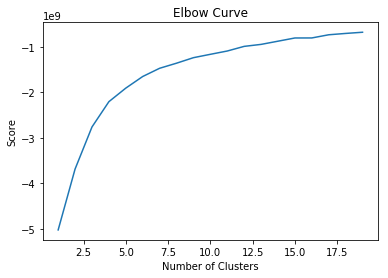

In [19]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(data).score(data) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [20]:
kclusters = 5

toronto_areas_clustering = df_demographic.drop('City_Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 0, 4, 1, 0, 1, 1, 1, 0])

In [21]:
# add clustering labels
areas_ethn_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [22]:

toronto_merged = df_cityAreas

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(areas_ethn_sorted.set_index(['City_Area']), on=['City_Area'])

toronto_merged.head(100) # check the last columns!


,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
0,129,Agincourt North,43.80930,-79.267070,3,Chinese,Sri Lankan,East Indian,Filipino,Canadian,English,Tamil,Jamaican,Scottish,Irish
1,128,Agincourt South-Malvern West,43.78736,-79.269350,3,Chinese,East Indian,Filipino,Sri Lankan,Canadian,English,Scottish,Jamaican,Italian,Irish
2,20,Alderwood,43.60496,-79.541160,0,English,Canadian,Irish,Scottish,Italian,Polish,German,French,Ukrainian,Portuguese
3,95,Annex,43.66936,-79.402800,4,English,Irish,Scottish,Canadian,German,French,Polish,Chinese,Italian,Russian
4,42,Banbury-Don Mills,43.74041,-79.348520,1,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French
5,34,Bathurst Manor,43.76378,-79.454770,0,Filipino,Russian,Italian,Polish,Canadian,Jewish,Chinese,English,Ukrainian,Greek
6,76,Bay Street Corridor,43.65771,-79.386180,1,Chinese,English,Canadian,Scottish,Irish,East Indian,Korean,German,French,Italian
7,52,Bayview Village,43.77710,-79.379570,1,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,East Indian,Filipino,Polish
8,49,Bayview Woods-Steeles,43.79485,-79.382220,1,Chinese,Iranian,English,Canadian,Korean,Polish,Irish,Scottish,Russian,East Indian
9,39,Bedford Park-Nortown,43.73066,-79.424500,0,Canadian,Polish,English,Russian,Scottish,Irish,Filipino,Jewish,German,Italian


In [23]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cityArea, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['City_Area'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(cityArea) + ' - Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [24]:
toronto_merged = toronto_merged[toronto_merged['Cluster Labels']!=0]
toronto_merged = toronto_merged[toronto_merged['Cluster Labels']!=3]
toronto_merged = toronto_merged[toronto_merged['Cluster Labels']!=4]

In [25]:
toronto_merged[toronto_merged['Cluster Labels']!=0]

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
4,42,Banbury-Don Mills,43.74041,-79.34852,1,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French
6,76,Bay Street Corridor,43.65771,-79.38618,1,Chinese,English,Canadian,Scottish,Irish,East Indian,Korean,German,French,Italian
7,52,Bayview Village,43.77710,-79.37957,1,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,East Indian,Filipino,Polish
8,49,Bayview Woods-Steeles,43.79485,-79.38222,1,Chinese,Iranian,English,Canadian,Korean,Polish,Irish,Scottish,Russian,East Indian
11,127,Bendale,43.75963,-79.25739,1,Chinese,East Indian,Filipino,Canadian,English,Scottish,Irish,Sri Lankan,Greek,French
30,47,Don Valley Village,43.78558,-79.34986,1,Chinese,Filipino,East Indian,Iranian,English,Canadian,Irish,Scottish,Korean,Armenian
31,126,Dorset Park,43.75533,-79.27746,1,Filipino,East Indian,Chinese,Canadian,Sri Lankan,English,Jamaican,Scottish,Tamil,Irish
48,53,Henry Farm,43.77229,-79.34086,1,Chinese,East Indian,Filipino,Iranian,Canadian,English,Scottish,Irish,Afghan,Korean
52,48,Hillcrest Village,43.80303,-79.35346,1,Chinese,East Indian,Canadian,Iranian,Korean,English,Russian,Scottish,Polish,Irish
62,78,Kensington-Chinatown,43.65331,-79.39634,1,Chinese,Canadian,English,Irish,Scottish,French,German,Italian,Polish,East Indian


In [26]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cityArea, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['City_Area'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(cityArea) + ' - Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [27]:
toronto_merged[toronto_merged['Cluster Labels'] == 2].head(50)

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
73,132,Malvern,43.81023,-79.22038,2,East Indian,Sri Lankan,Filipino,Chinese,Jamaican,Canadian,English,Tamil,Guyanese,Pakistani
81,2,Mount Olive-Silverstone-Jamestown,43.74721,-79.58826,2,East Indian,Iraqi,Jamaican,Canadian,Somali,Italian,Assyrian,Sri Lankan,Other African origins; n.i.e.,Ghanaian
105,131,Rouge,43.80766,-79.17405,2,East Indian,Sri Lankan,Canadian,Filipino,Jamaican,English,Chinese,Tamil,Scottish,Irish
124,1,West Humber-Clairville,43.71456,-79.59261,2,East Indian,Jamaican,Canadian,Filipino,Italian,Punjabi,English,Guyanese,Chinese,Scottish
132,137,Woburn,43.76748,-79.22829,2,East Indian,Canadian,Sri Lankan,Chinese,Filipino,English,Irish,Scottish,Jamaican,Tamil


In [28]:
toronto_merged[toronto_merged['Cluster Labels'] == 1].head(50)

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
4,42,Banbury-Don Mills,43.74041,-79.34852,1,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French
6,76,Bay Street Corridor,43.65771,-79.38618,1,Chinese,English,Canadian,Scottish,Irish,East Indian,Korean,German,French,Italian
7,52,Bayview Village,43.77710,-79.37957,1,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,East Indian,Filipino,Polish
8,49,Bayview Woods-Steeles,43.79485,-79.38222,1,Chinese,Iranian,English,Canadian,Korean,Polish,Irish,Scottish,Russian,East Indian
11,127,Bendale,43.75963,-79.25739,1,Chinese,East Indian,Filipino,Canadian,English,Scottish,Irish,Sri Lankan,Greek,French
30,47,Don Valley Village,43.78558,-79.34986,1,Chinese,Filipino,East Indian,Iranian,English,Canadian,Irish,Scottish,Korean,Armenian
31,126,Dorset Park,43.75533,-79.27746,1,Filipino,East Indian,Chinese,Canadian,Sri Lankan,English,Jamaican,Scottish,Tamil,Irish
48,53,Henry Farm,43.77229,-79.34086,1,Chinese,East Indian,Filipino,Iranian,Canadian,English,Scottish,Irish,Afghan,Korean
52,48,Hillcrest Village,43.80303,-79.35346,1,Chinese,East Indian,Canadian,Iranian,Korean,English,Russian,Scottish,Polish,Irish
62,78,Kensington-Chinatown,43.65331,-79.39634,1,Chinese,Canadian,English,Irish,Scottish,French,German,Italian,Polish,East Indian


In [29]:
def getNearbyVenues(cdn, latitudes, longitudes):
    
    venues_list=[]
    # Loop through each neighbourhood given in parameters
    for cdn, lat, lng in zip(cdn, latitudes, longitudes):

        # create the API request URL to explore the neighbourhood using FoursquareAPI
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            CONST_venuesRadiusScan, 
            CONST_venuesLimit)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue : name, latitude, longitude, and the categories' names
        venues_list.append([(
            cdn,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    # add the venues in the dataframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                        'CDN',
                        'Area Latitude', 
                        'Area Longitude', 
                        'Venue', 
                        'Venue Latitude', 
                        'Venue Longitude', 
                        'Venue Category'
    ]
    
    return(nearby_venues)


In [39]:
toronto_indian = toronto_merged[(toronto_merged['Cluster Labels'] == 2)| (toronto_merged['Cluster Labels'] == 1)]

toronto_indian

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin
4,42,Banbury-Don Mills,43.74041,-79.34852,1,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French
6,76,Bay Street Corridor,43.65771,-79.38618,1,Chinese,English,Canadian,Scottish,Irish,East Indian,Korean,German,French,Italian
7,52,Bayview Village,43.77710,-79.37957,1,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,East Indian,Filipino,Polish
8,49,Bayview Woods-Steeles,43.79485,-79.38222,1,Chinese,Iranian,English,Canadian,Korean,Polish,Irish,Scottish,Russian,East Indian
11,127,Bendale,43.75963,-79.25739,1,Chinese,East Indian,Filipino,Canadian,English,Scottish,Irish,Sri Lankan,Greek,French
30,47,Don Valley Village,43.78558,-79.34986,1,Chinese,Filipino,East Indian,Iranian,English,Canadian,Irish,Scottish,Korean,Armenian
31,126,Dorset Park,43.75533,-79.27746,1,Filipino,East Indian,Chinese,Canadian,Sri Lankan,English,Jamaican,Scottish,Tamil,Irish
48,53,Henry Farm,43.77229,-79.34086,1,Chinese,East Indian,Filipino,Iranian,Canadian,English,Scottish,Irish,Afghan,Korean
52,48,Hillcrest Village,43.80303,-79.35346,1,Chinese,East Indian,Canadian,Iranian,Korean,English,Russian,Scottish,Polish,Irish
62,78,Kensington-Chinatown,43.65331,-79.39634,1,Chinese,Canadian,English,Irish,Scottish,French,German,Italian,Polish,East Indian


In [40]:
# Get the venues for each neighbourhood
indian_restaurants_venues = getNearbyVenues(  
                                    cdn=toronto_indian['CDN'],
                                    latitudes=toronto_indian['Latitude'],
                                    longitudes=toronto_indian['Longitude']
                                  )

indian_restaurants_venues[(indian_restaurants_venues['Venue Category'] == "Indian Restaurant")].head()

,CDN,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
193,127,43.75963,-79.25739,Pak Centre,43.752141,-79.261693,Indian Restaurant
262,126,43.75533,-79.27746,Kairali,43.754915,-79.276945,Indian Restaurant
271,126,43.75533,-79.27746,Karaikudi Chettinad South Indian Restaurant,43.756042,-79.276276,Indian Restaurant
374,48,43.80303,-79.35346,Mistaan Catering & Sweets,43.804522,-79.341910,Indian Restaurant
543,36,43.78818,-79.43173,The Indian Cuisine,43.795327,-79.434607,Indian Restaurant


In [41]:
indian_restaurants_count = indian_restaurants_venues.groupby(['CDN','Area Latitude', 'Area Longitude']).count().reset_index()

# Drop the useless columns
indian_restaurants_count = indian_restaurants_count.drop(indian_restaurants_count.columns[[1,2,3,4,5]], axis=1)
indian_restaurants_count.columns = ['CDN', 'Count']

# Merge the counts with the toronto_chinese dataframe
toronto_indian = toronto_indian.join(indian_restaurants_count.set_index(['CDN']), on=['CDN'])
toronto_chinese = toronto_indian.sort_values(by='Count')

toronto_indian.head()

,CDN,City_Area,Latitude,Longitude,Cluster Labels,1st Most Common Origin,2nd Most Common Origin,3rd Most Common Origin,4th Most Common Origin,5th Most Common Origin,6th Most Common Origin,7th Most Common Origin,8th Most Common Origin,9th Most Common Origin,10th Most Common Origin,Count
4,42,Banbury-Don Mills,43.74041,-79.34852,1,Chinese,English,Irish,Canadian,Scottish,East Indian,German,Filipino,Polish,French,39
6,76,Bay Street Corridor,43.65771,-79.38618,1,Chinese,English,Canadian,Scottish,Irish,East Indian,Korean,German,French,Italian,100
7,52,Bayview Village,43.77710,-79.37957,1,Chinese,Iranian,Korean,English,Canadian,Irish,Scottish,East Indian,Filipino,Polish,26
8,49,Bayview Woods-Steeles,43.79485,-79.38222,1,Chinese,Iranian,English,Canadian,Korean,Polish,Irish,Scottish,Russian,East Indian,13
11,127,Bendale,43.75963,-79.25739,1,Chinese,East Indian,Filipino,Canadian,English,Scottish,Irish,Sri Lankan,Greek,French,18


In [42]:
toronto_indian_top = toronto_indian.head(100)

# create map of Toronto using latitude and longitude values
spots_indian_restaurants = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=11)

# add markers to map
for lat, lng, CDN, City_Area in zip(toronto_indian_top['Latitude'], toronto_indian_top['Longitude'], toronto_indian_top['CDN'], toronto_indian_top['City_Area']):
    label = '{} - {}'.format(CDN, City_Area)
    label = folium.Popup(label, parse_html=True)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(spots_indian_restaurants) 
    
spots_indian_restaurants

In [43]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cityArea, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['City_Area'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(cityArea) + ' - Cluster ' + str(cluster), parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters